<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Data Cleaning and Exploratory Data Analysis

> Authors: Lim Zheng Gang, Eugene Matthew Cheong, Pius Yee

---

### Problem statement:

Our current manual process of evaluating property data for customers is time-consuming and prone to inconsistencies, as it relies on individual agents generating analyses independently. 

To address this challenge, we have developed a model for this project, aimed at empowering our agents to deliver consistent property evaluations to customers. 

By leveraging this model, our agents can provide invaluable insights and make data-driven decisions, ensuring a standardized approach to property valuation.


In [1]:
# import libraries

from datetime import datetime
import math

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


import scipy
from scipy.stats import pearsonr
from scipy.spatial.distance import cityblock

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

import category_encoders as ce


pd.set_option('display.max_columns', None)

### Read the CSV file and check for missing values

In [2]:
# read csv file
hdb_raw = pd.read_csv("../datasets/train.csv", low_memory=False)

In [3]:
# check for missing values

hdb_raw[hdb_raw.columns[hdb_raw.isnull().any()]].isnull().sum()

Mall_Nearest_Distance      829
Mall_Within_500m         92789
Mall_Within_1km          25426
Mall_Within_2km           1940
Hawker_Within_500m       97390
Hawker_Within_1km        60868
Hawker_Within_2km        29202
dtype: int64

##### There are 7 columns with missing values. We will consider the context of each columns and replace the missing values with appropriate values.

In [4]:
hdb_raw.head()

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,Tranc_Year,Tranc_Month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,price_per_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,Latitude,Longitude,planning_area,Mall_Nearest_Distance,Mall_Within_500m,Mall_Within_1km,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_500m,Hawker_Within_1km,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,680000.0,2016,5,11,10,12,11,4 ROOM Model A,"3B, UPP BOON KENG RD",968.760,701.928238,15,25,2005,Y,N,N,N,N,142,0,0,0,96,46,0,0,0,0,0,0,0,382003,1.314299,103.872828,Kallang,1094.090418,NaN,NaN,7.0,154.753357,1.0,3.0,13.0,84,60,330.083069,Kallang,0,0,1.311540,103.871731,29.427395,Blk 3B,1.314433,103.872600,1138.633422,Geylang Methodist School,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,665000.0,2012,7,8,7,9,8,5 ROOM Improved,"153, BISHAN ST 13",1399.320,475.230826,34,9,1987,Y,N,N,N,N,112,0,0,0,56,56,0,0,0,0,0,0,0,570153,1.346086,103.855078,Bishan,866.941448,NaN,1.0,3.0,640.151925,NaN,1.0,7.0,80,77,903.659703,Bishan,1,1,1.350580,103.848305,58.207761,BLK 151A MKT,1.345659,103.855381,415.607357,Kuo Chuan Presbyterian Primary School,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892
2,170897,2013-07,BUKIT BATOK,EXECUTIVE,289B,BT BATOK ST 25,13 TO 15,144.0,Apartment,1997,838000.0,2013,7,14,13,15,14,EXECUTIVE Apartment,"289B, BT BATOK ST 25",1550.016,540.639580,24,16,1996,Y,N,N,N,N,90,0,0,0,0,30,60,0,0,0,0,0,0,651289,1.343867,103.760535,Bukit Batok,1459.579948,NaN,NaN,4.0,1762.082341,NaN,NaN,1.0,84,95,1334.251197,Bukit Batok,1,0,1.349561,103.749970,214.747860,Blk 289E,1.344064,103.758613,498.849039,Keming Primary School,39,0,1.345245,103.756265,180.074558,Yusof Ishak Secondary School,188,0,1.342334,103.760013
3,86070,2012-04,BISHAN,4 ROOM,232,BISHAN ST 22,01 TO 05,103.0,Model A,1992,550000.0,2012,4,3,1,5,3,4 ROOM Model A,"232, BISHAN ST 22",1108.692,496.080066,29,11,1990,Y,Y,N,N,N,75,0,0,0,68,7,0,0,0,0,0,0,0,570232,1.358245,103.845504,Bishan,950.175199,NaN,1.0,4.0,726.215262,NaN,1.0,9.0,32,86,907.453484,Bishan,1,1,1.350580,103.848305,43.396521,Opp Bishan Nth Shop Mall,1.358045,103.845169,389.515528,Catholic High School,20,1,1.354789,103.844934,389.515528,Catholic High School,253,1,1.354789,103.844934
4,153632,2017-12,YISHUN,4 ROOM,876,YISHUN ST 81,01 TO 03,83.0,Simplified,1987,298000.0,2017,12,2,1,3,2,4 ROOM Simplified,"876, YISHUN ST 81",893.412,333.552717,34,4,1987,Y,N,N,N,N,48,0,0,0,30,18,0,0,0,0,0,0,0,760876,1.414745,103.835532,Yishun,729.771895,NaN,1.0,2.0,1540.151439,NaN,NaN,1.0,45,0,412.343032,Khatib,0,0,1.417131,103.832692,129.422752,Blk 873,1.415424,103.836477,401.200584,Naval Base Primary School,74,0,1.416280,103.838798,312.025435,Orchid Park Secondary School,208,0,1.414888,103.838335


##### After analyzing the missing value, we will use the following strategies to address them:

In [5]:
# Mall_Nearest_Distance - Since the missing value cannot be imputed meaningfully, we'll remove the affected rows. The number of rows is immaterial to our analysis.

hdb_df = hdb_raw.copy()
hdb_df = hdb_df.dropna(subset='Mall_Nearest_Distance')
hdb_df = hdb_df.reset_index(drop=True)

In [6]:
# Replace with 0 for the rest of columns with missing values

hdb_df[['Mall_Within_500m','Mall_Within_1km','Mall_Within_2km','Hawker_Within_500m','Hawker_Within_1km','Hawker_Within_2km']] = hdb_df[['Mall_Within_500m','Mall_Within_1km','Mall_Within_2km','Hawker_Within_500m','Hawker_Within_1km','Hawker_Within_2km']].fillna(0)

In [7]:
# check for missing values

hdb_df[hdb_df.columns[hdb_df.isnull().any()]].isnull().sum()

Series([], dtype: float64)

In [8]:
hdb_df.flat_type.unique()

array(['4 ROOM', '5 ROOM', 'EXECUTIVE', '3 ROOM', '2 ROOM', '1 ROOM',
       'MULTI-GENERATION'], dtype=object)

##### No more missing value and no issue with data type.

In [9]:
hdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149805 entries, 0 to 149804
Data columns (total 78 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         149805 non-null  int64  
 1   Tranc_YearMonth            149805 non-null  object 
 2   town                       149805 non-null  object 
 3   flat_type                  149805 non-null  object 
 4   block                      149805 non-null  object 
 5   street_name                149805 non-null  object 
 6   storey_range               149805 non-null  object 
 7   floor_area_sqm             149805 non-null  float64
 8   flat_model                 149805 non-null  object 
 9   lease_commence_date        149805 non-null  int64  
 10  resale_price               149805 non-null  float64
 11  Tranc_Year                 149805 non-null  int64  
 12  Tranc_Month                149805 non-null  int64  
 13  mid_storey                 14

##### All missing values are cleared.
##### We see columns with Y/N values. We change them to having 0 and 1 for easy analysis. 

In [10]:
# changing the value "Y" to 1 and "N" to 0

col_Y_N = ['commercial','market_hawker','multistorey_carpark','precinct_pavilion']

for col in col_Y_N:
    hdb_df[col] = hdb_df[col].str.replace('N','0')
    hdb_df[col] = hdb_df[col].str.replace('Y','1').astype("int")

##### There are too many columns. We will drop the some columns where it is obvious that there are similar proxies on a more granular level or those that we will not be using the analysis. Note that we removed lat long since they do not present a linear relationship with pricing. But this is an important set of data. We will proxy the relationship using planning area. 

In [11]:
#Columns to drop
columns_to_drop = [
    "Tranc_YearMonth",
    "town",
    "block",
    "price_per_sqft",
    "street_name",
    "storey_range",
    "floor_area_sqm",
    "mid_storey",
    "lower",
    "upper",
    "full_flat_type",
    "address",
    "residential",
    "1room_rental",
    "2room_rental",
    "3room_rental",
    "other_room_rental",
    "postal",
    "mrt_name",
    "mrt_latitude",
    "mrt_longitude",
    "bus_stop_name",
    "bus_stop_latitude",
    "bus_stop_longitude",
    "pri_sch_name",
    "pri_sch_latitude",
    "pri_sch_longitude",
    "sec_sch_name",
    "sec_sch_latitude",
    "sec_sch_longitude",
]

hdb_df = hdb_df.drop(columns = columns_to_drop)

In [12]:
#Export the cleaned data to CSV
hdb_df.to_csv('../datasets/hdb_cleaned.csv')

In [13]:
hdb_df.head()

,id,flat_type,flat_model,lease_commence_date,resale_price,Tranc_Year,Tranc_Month,mid,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,Latitude,Longitude,planning_area,Mall_Nearest_Distance,Mall_Within_500m,Mall_Within_1km,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_500m,Hawker_Within_1km,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation
0,88471,4 ROOM,Model A,2006,680000.0,2016,5,11,968.760,15,25,2005,0,0,0,0,142,0,0,0,96,46,0,0,0,1.314299,103.872828,Kallang,1094.090418,0.0,0.0,7.0,154.753357,1.0,3.0,13.0,84,60,330.083069,0,0,29.427395,1138.633422,78,1,1138.633422,224,0
1,122598,5 ROOM,Improved,1987,665000.0,2012,7,8,1399.320,34,9,1987,0,0,0,0,112,0,0,0,56,56,0,0,0,1.346086,103.855078,Bishan,866.941448,0.0,1.0,3.0,640.151925,0.0,1.0,7.0,80,77,903.659703,1,1,58.207761,415.607357,45,1,447.894399,232,0
2,170897,EXECUTIVE,Apartment,1997,838000.0,2013,7,14,1550.016,24,16,1996,0,0,0,0,90,0,0,0,0,30,60,0,0,1.343867,103.760535,Bukit Batok,1459.579948,0.0,0.0,4.0,1762.082341,0.0,0.0,1.0,84,95,1334.251197,1,0,214.747860,498.849039,39,0,180.074558,188,0
3,86070,4 ROOM,Model A,1992,550000.0,2012,4,3,1108.692,29,11,1990,1,0,0,0,75,0,0,0,68,7,0,0,0,1.358245,103.845504,Bishan,950.175199,0.0,1.0,4.0,726.215262,0.0,1.0,9.0,32,86,907.453484,1,1,43.396521,389.515528,20,1,389.515528,253,1
4,153632,4 ROOM,Simplified,1987,298000.0,2017,12,2,893.412,34,4,1987,0,0,0,0,48,0,0,0,30,18,0,0,0,1.414745,103.835532,Yishun,729.771895,0.0,1.0,2.0,1540.151439,0.0,0.0,1.0,45,0,412.343032,0,0,129.422752,401.200584,74,0,312.025435,208,0


### EDA

##### Trend for HDB resale price

Text(0.5, 1.0, 'HDB Resale price from 2012 to 2021')

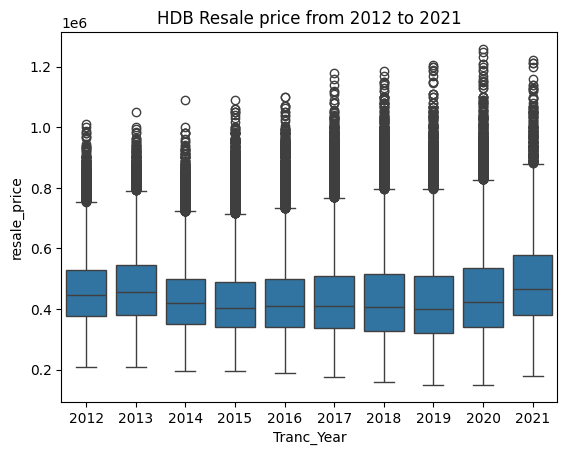

In [14]:
#boxplots for resale price over years
sns.boxplot(data=hdb_raw[['Tranc_Year','resale_price']].sort_values(by='Tranc_Year'),x="Tranc_Year",y="resale_price");
plt.title("HDB Resale price from 2012 to 2021")

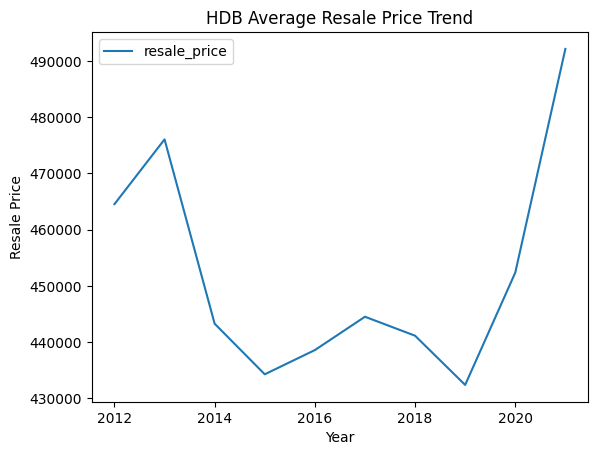

In [15]:
# line chart
hdb_raw[['resale_price','Tranc_Year']].groupby("Tranc_Year").mean().plot(title='HDB Average Resale Price Trend',xlabel="Year",ylabel="Resale Price");

##### The average resale price were fluctuated before 2020, but it spikes high after 2020 due to covid
----

Text(0.5, 1.0, 'Histogram for price per sqft by flat_type')

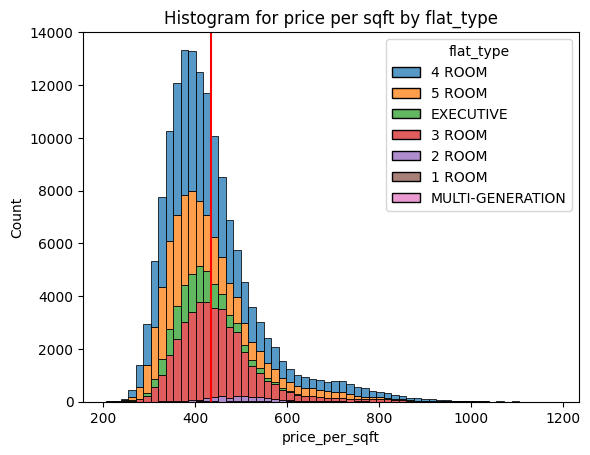

In [16]:
#histogram for resale price by flat type
sns.histplot(hdb_raw,x='price_per_sqft', hue = 'flat_type', bins=60,multiple='stack')
plt.axvline(x=hdb_raw.price_per_sqft.mean(), color = 'red')
plt.title("Histogram for price per sqft by flat_type")

##### Based on the histogram above, red line is the mean of resale price for all flat type. It shows the distributions of different flat type for resale price.
##### Interestingly, the distribution of flat sizes across all types follows a normal curve. Additionally, the price per square foot exhibits similar patterns for each flat type, with their average prices (means) being relatively close.

##### Overall number of flats sold by flat type

<Axes: title={'center': 'Number of flats sold by type'}, xlabel='Tranc_Year'>

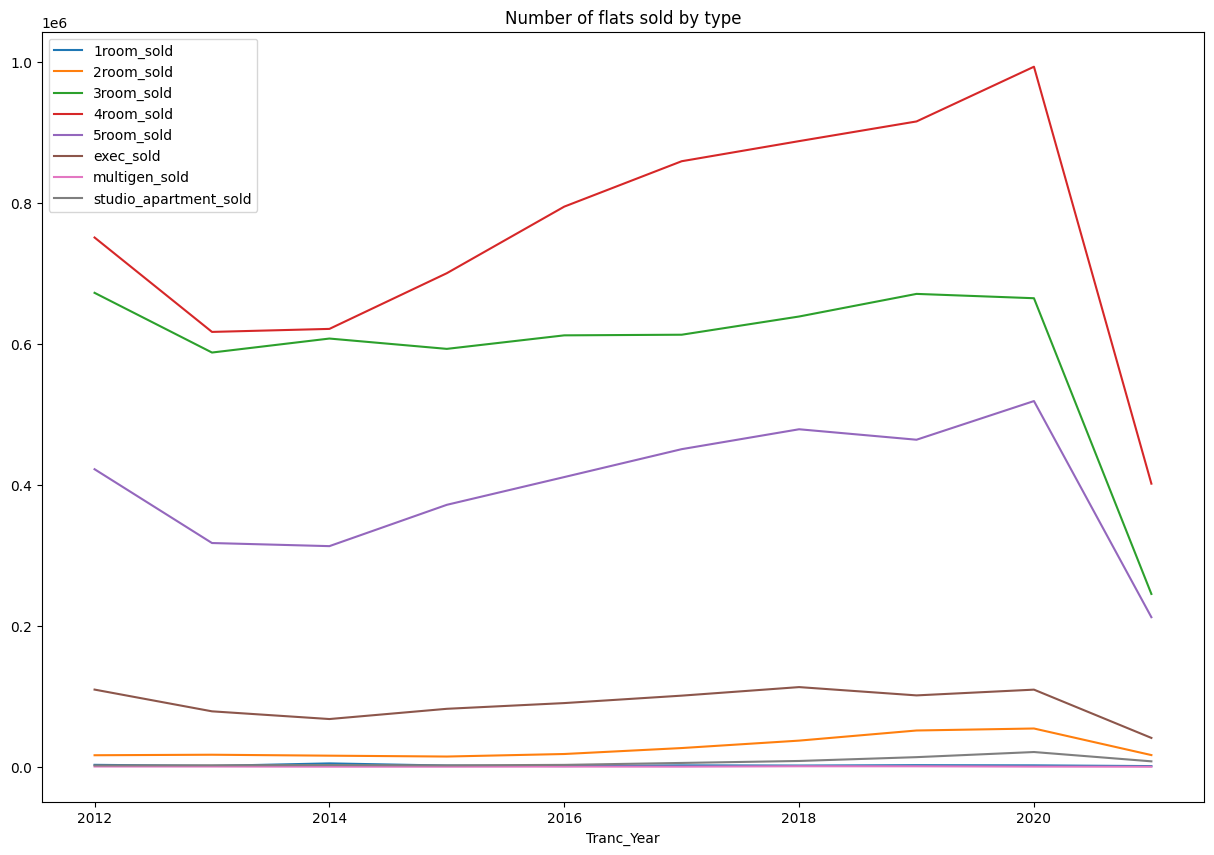

In [17]:
hdb_raw[['Tranc_Year','1room_sold','2room_sold','3room_sold','4room_sold','5room_sold','exec_sold','multigen_sold','studio_apartment_sold']].groupby("Tranc_Year").sum().plot(title="Number of flats sold by type",figsize=(15,10))

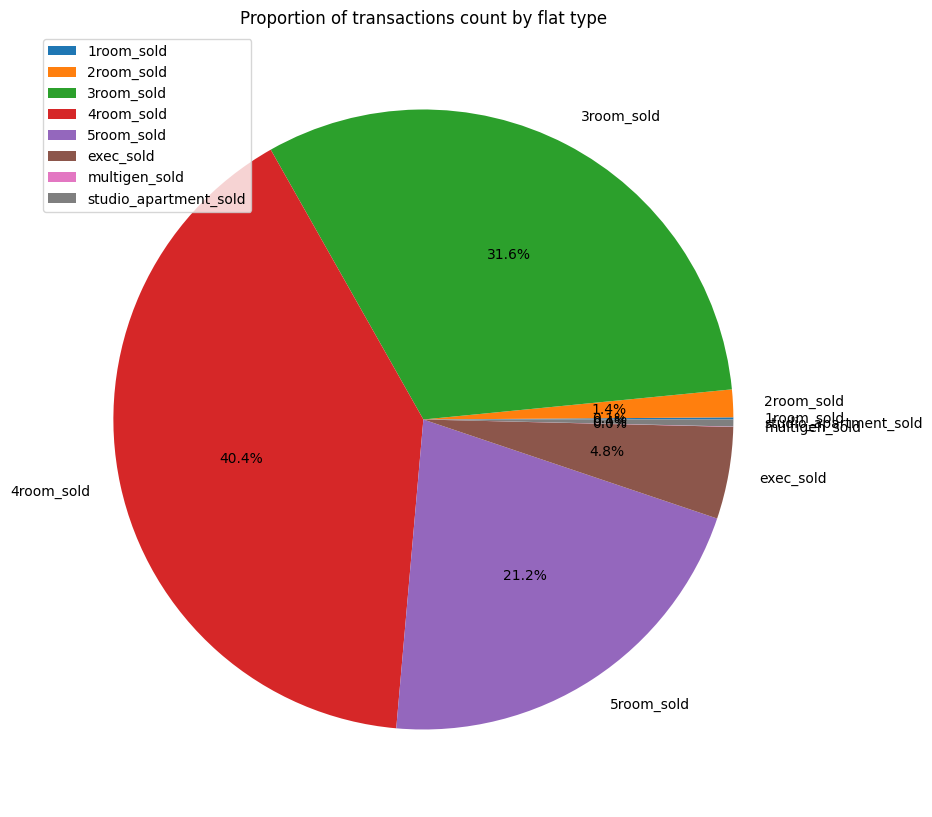

In [18]:
# Overall number of flats sold by flat type

hdb_raw[['1room_sold','2room_sold','3room_sold','4room_sold','5room_sold','exec_sold','multigen_sold','studio_apartment_sold']].sum().plot(kind='pie',figsize=(10,15), autopct="%1.1f%%", title="Proportion of transactions count by flat type")
plt.legend()

##### As shown above, 4-room has the highest number of transactions in the dataset.

----

##### Highest and Lowest average HDB price by planning area

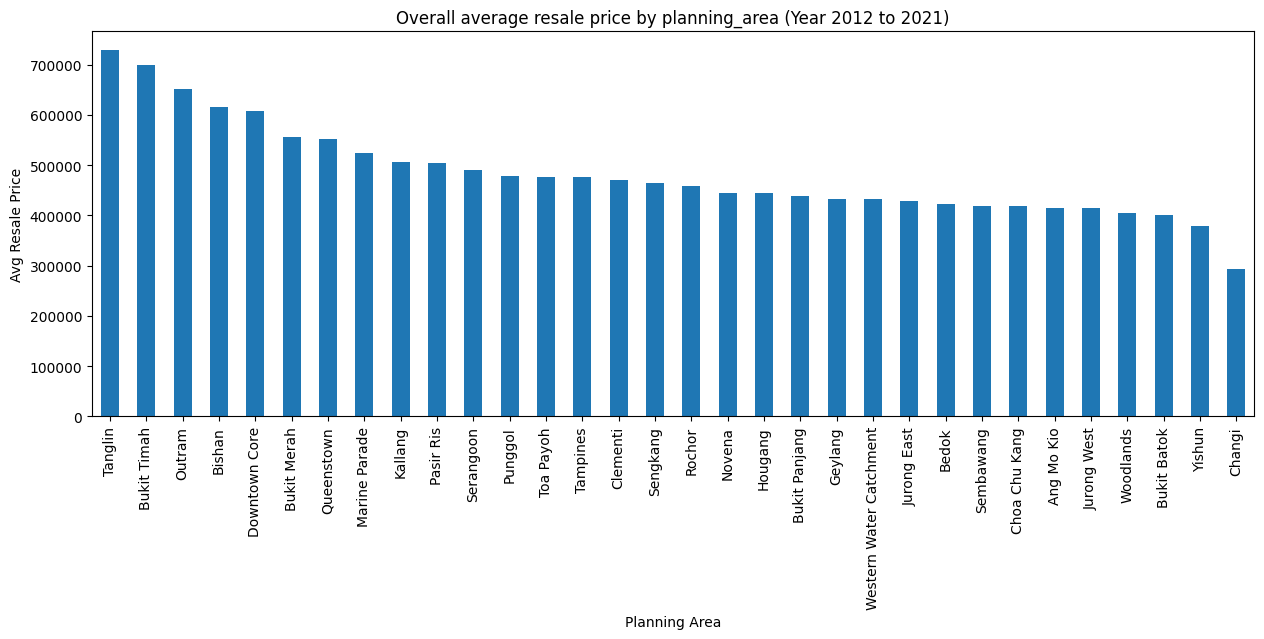

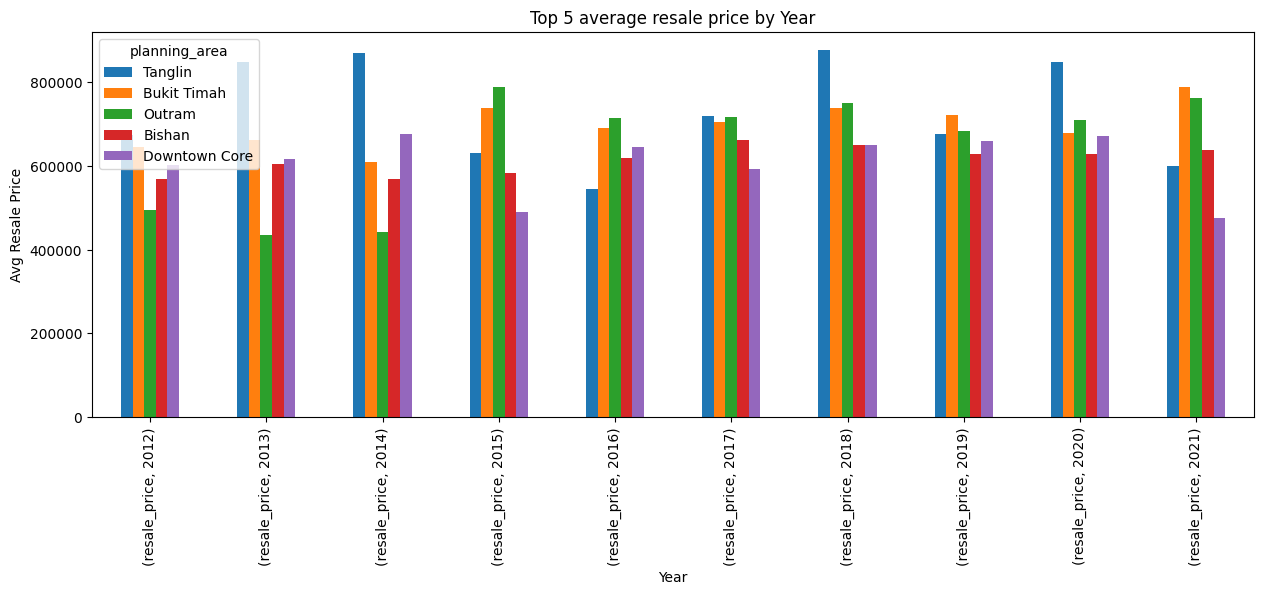

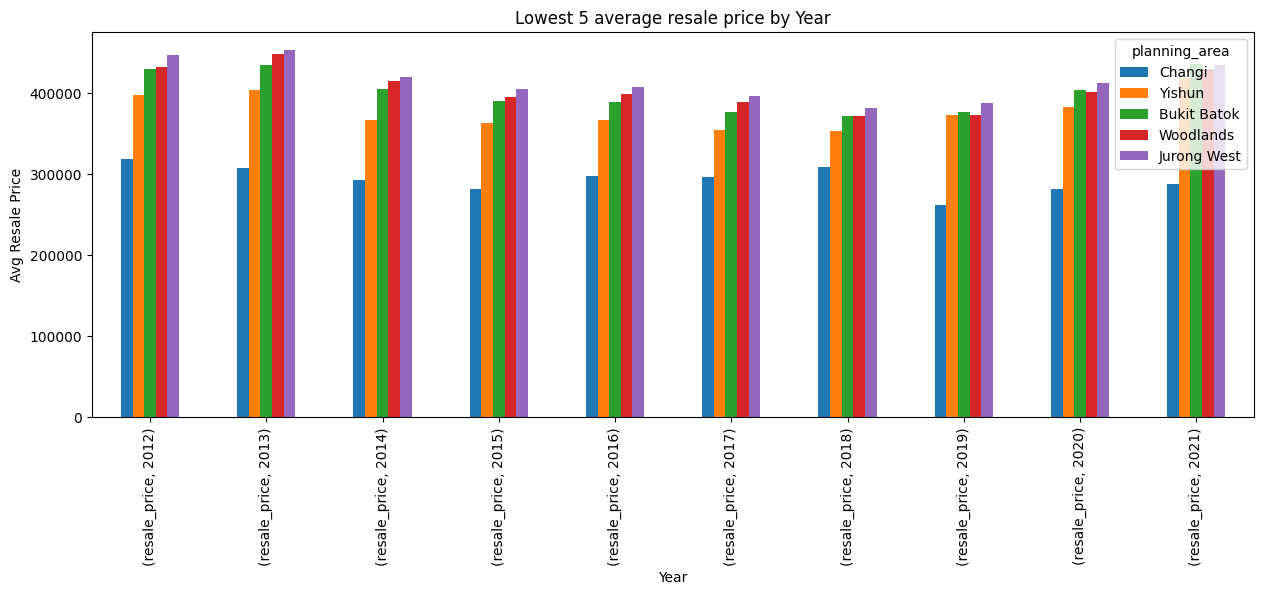

In [19]:
area_year = hdb_raw[['planning_area','resale_price','Tranc_Year']].groupby(['planning_area','Tranc_Year']).mean().sort_values(by='resale_price',ascending=False)
area_year = area_year.unstack('Tranc_Year')
area_year['avg'] = area_year.mean(axis=1)
area_year = area_year.transpose()
area_year.iloc[-1].sort_values(ascending=False).plot(kind='bar',figsize=(15,5),title = 'Overall average resale price by planning_area (Year 2012 to 2021)',xlabel='Planning Area',ylabel='Avg Resale Price');
area_year.sort_values(by=('avg',''),axis=1,ascending=False).iloc[:-1,:5].plot(kind='bar',figsize=(15,5),title = 'Top 5 average resale price by Year',xlabel='Year',ylabel='Avg Resale Price');
area_year.sort_values(by=('avg',''),axis=1,ascending=True).iloc[:-1,:5].plot(kind='bar',figsize=(15,5),title = 'Lowest 5 average resale price by Year',xlabel='Year',ylabel='Avg Resale Price');

##### As aboved, the planning area is a very important feature for HDB resale price. We should always consider about the planning area when predicting HDB resale price.

##### Explore the correlation between mall, MRT, hawker and school distance with resale price

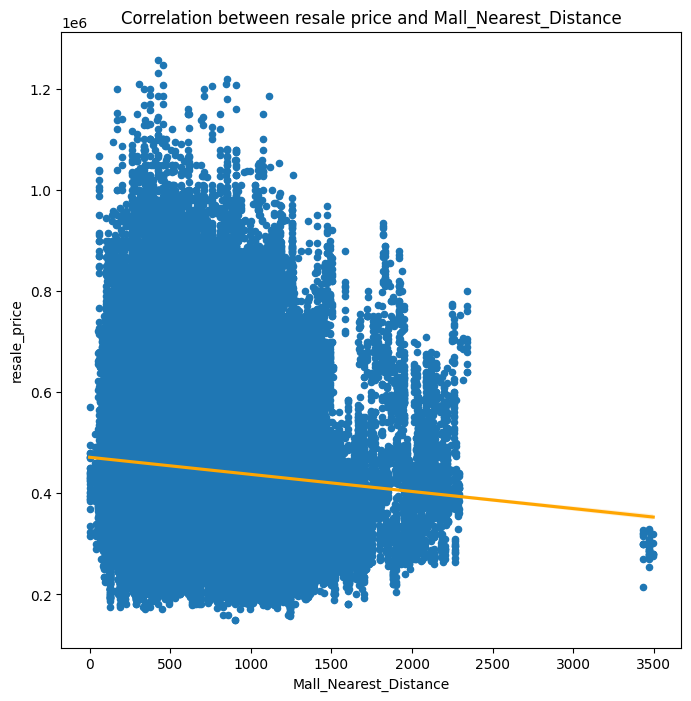

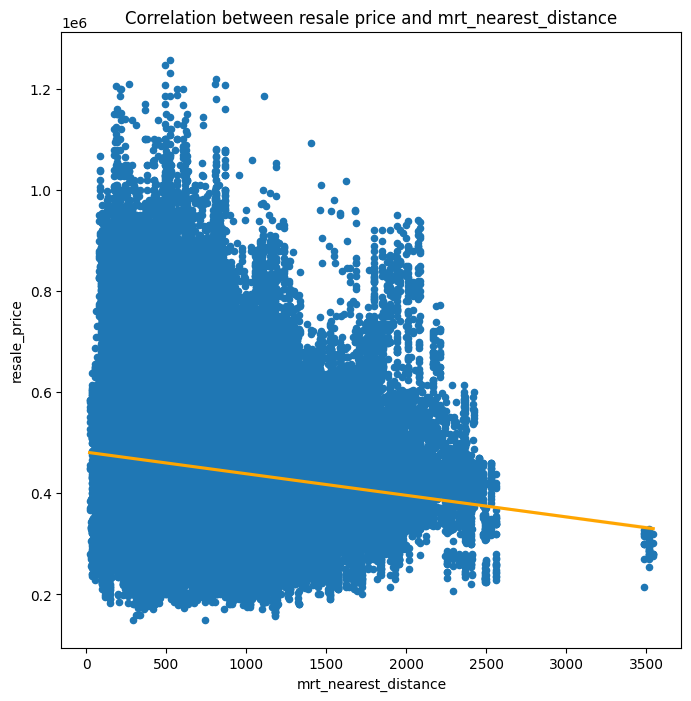

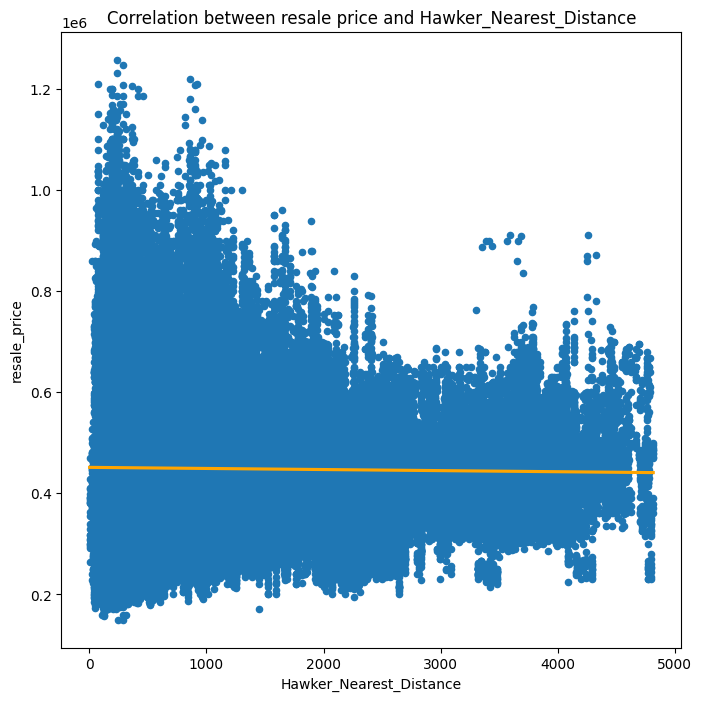

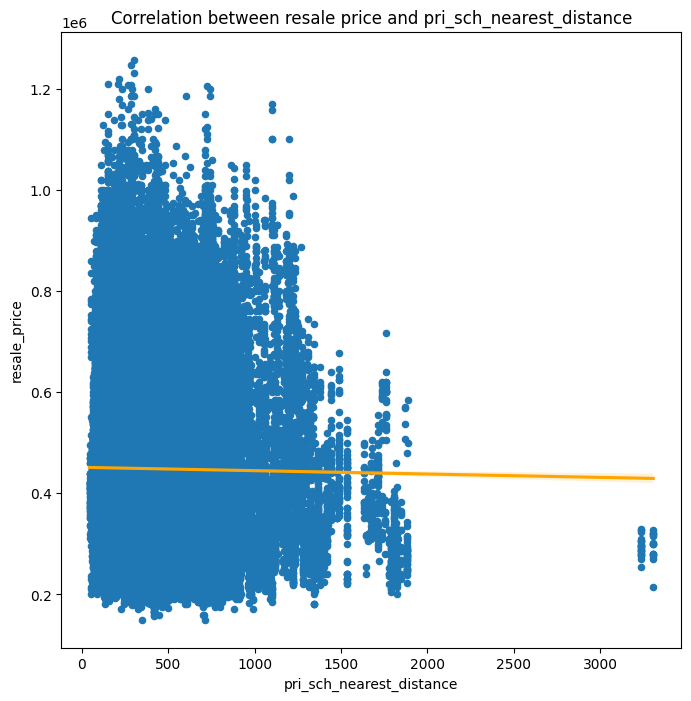

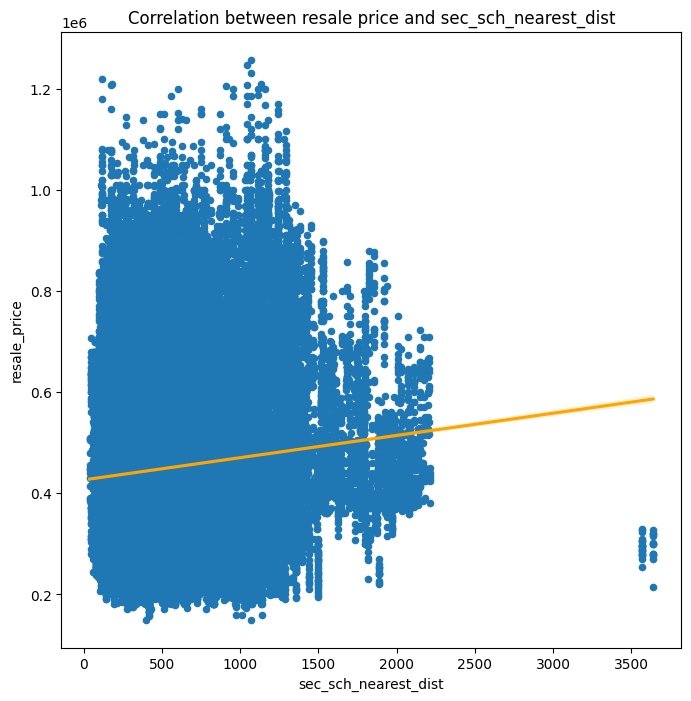

In [20]:
for dist in ["Mall_Nearest_Distance","mrt_nearest_distance","Hawker_Nearest_Distance",'pri_sch_nearest_distance','sec_sch_nearest_dist']:
    hdb_df.plot(kind='scatter',x=dist,y='resale_price',title= ("Correlation between resale price and " +dist),figsize=(8,8))
    sns.regplot(data=hdb_df, x=dist, y='resale_price', scatter=False,color="Orange")

##### MRT distance has a clear positive correlation with resale price. However, the distance to hawker centers and malls does not show a positive correlation. This suggests that proximity to hawker centers and malls may not necessarily influence resale price.

##### Amenities to resale price

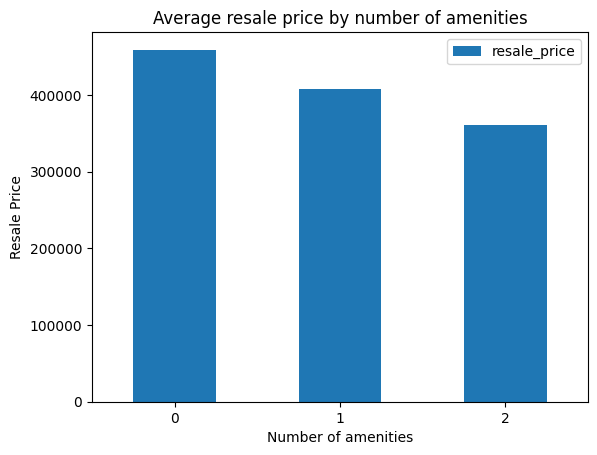

In [21]:
hdb_ame = hdb_raw[['resale_price'] + ['commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']].assign(count_ame=lambda x: x[['commercial', 'market_hawker', 'multistorey_carpark', 'precinct_pavilion']].eq('Y').sum(axis=1))
hdb_ame[['resale_price','count_ame']].groupby('count_ame').mean().plot(kind='bar',xlabel='Number of amenities',ylabel='Resale Price',title='Average resale price by number of amenities')
plt.xticks(rotation=0)
sns.set_palette("Set3")

##### Suprisingly the resale price decrease as the number of amenities increases.

### Score for the baseline data frame

##### Now that we've cleaned the data and removed features irrelevant to resale price prediction, this serves as our baseline model. We'll further tune it in the next notebook, aiming to achieve a more accurate model compared to this baseline.

In [22]:
# create a new dataframe for baseline model
hdb_base = hdb_df.copy()

In [23]:
# Total number of features for the baseline model
print(f'Total features for the baseline model is {len(hdb_base.columns)}.')

Total features for the baseline model is 48.


In [24]:
# Using Linear Regression to assess the score.
lr = LinearRegression()

In [25]:
X = hdb_base.drop(columns=['id','resale_price','flat_model','planning_area','flat_type'])
y = hdb_base['resale_price'].values 

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(scaler.fit_transform(X), np.log1p(y), random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

{"r2": metrics.r2_score(y_test, y_pred) ,"r2 for train set": lr.score(X_train,y_train), "r2 for test set": lr.score(X_test,y_test), "cross val": cross_val_score(lr, X_train, y_train, cv=10).mean(), "MSE": metrics.mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1),"RMSE": metrics.mean_squared_error(np.exp(y_test)-1, np.exp(y_pred)-1, squared=False),"MAE": metrics.mean_absolute_error(np.exp(y_test)-1, np.exp(y_pred)-1)}


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'r2': 0.8479875066089313,
 'r2 for train set': 0.8493956695828312,
 'r2 for test set': 0.8479875066089313,
 'cross val': 0.8492488797405656,
 'MSE': 3296633213.9747343,
 'RMSE': 57416.31487630266,
 'MAE': 40961.508787954685}

In [26]:
hdb_base.head()

,id,flat_type,flat_model,lease_commence_date,resale_price,Tranc_Year,Tranc_Month,mid,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,Latitude,Longitude,planning_area,Mall_Nearest_Distance,Mall_Within_500m,Mall_Within_1km,Mall_Within_2km,Hawker_Nearest_Distance,Hawker_Within_500m,Hawker_Within_1km,Hawker_Within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation
0,88471,4 ROOM,Model A,2006,680000.0,2016,5,11,968.760,15,25,2005,0,0,0,0,142,0,0,0,96,46,0,0,0,1.314299,103.872828,Kallang,1094.090418,0.0,0.0,7.0,154.753357,1.0,3.0,13.0,84,60,330.083069,0,0,29.427395,1138.633422,78,1,1138.633422,224,0
1,122598,5 ROOM,Improved,1987,665000.0,2012,7,8,1399.320,34,9,1987,0,0,0,0,112,0,0,0,56,56,0,0,0,1.346086,103.855078,Bishan,866.941448,0.0,1.0,3.0,640.151925,0.0,1.0,7.0,80,77,903.659703,1,1,58.207761,415.607357,45,1,447.894399,232,0
2,170897,EXECUTIVE,Apartment,1997,838000.0,2013,7,14,1550.016,24,16,1996,0,0,0,0,90,0,0,0,0,30,60,0,0,1.343867,103.760535,Bukit Batok,1459.579948,0.0,0.0,4.0,1762.082341,0.0,0.0,1.0,84,95,1334.251197,1,0,214.747860,498.849039,39,0,180.074558,188,0
3,86070,4 ROOM,Model A,1992,550000.0,2012,4,3,1108.692,29,11,1990,1,0,0,0,75,0,0,0,68,7,0,0,0,1.358245,103.845504,Bishan,950.175199,0.0,1.0,4.0,726.215262,0.0,1.0,9.0,32,86,907.453484,1,1,43.396521,389.515528,20,1,389.515528,253,1
4,153632,4 ROOM,Simplified,1987,298000.0,2017,12,2,893.412,34,4,1987,0,0,0,0,48,0,0,0,30,18,0,0,0,1.414745,103.835532,Yishun,729.771895,0.0,1.0,2.0,1540.151439,0.0,0.0,1.0,45,0,412.343032,0,0,129.422752,401.200584,74,0,312.025435,208,0


In [27]:
# create a VIF dataframe to perform the test
X= hdb_base.drop(columns=['id','resale_price','flat_model','planning_area','flat_type'])

vif_data = pd.DataFrame() 

scaler = StandardScaler()
X_scaled2 = scaler.fit_transform(X)

vif_data["feature"] = X.columns
  
vif_data["VIF"] = [variance_inflation_factor(X_scaled2, i) 
                   for i in range(X_scaled2.shape[1])]

print(vif_data)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                      feature        VIF
0         lease_commence_date        inf
1                  Tranc_Year   1.061899
2                 Tranc_Month   1.007442
3                         mid   1.446261
4             floor_area_sqft   2.892527
5                     hdb_age        inf
6               max_floor_lvl   3.457093
7              year_completed  50.531221
8                  commercial   1.085904
9               market_hawker   1.018626
10        multistorey_carpark   1.004419
11          precinct_pavilion   1.073796
12       total_dwelling_units  26.747060
13                 1room_sold   1.301086
14                 2room_sold   2.872052
15                 3room_sold  37.417244
16                 4room_sold  17.674559
17                 5room_sold  11.386325
18                  exec_sold   5.272508
19              multigen_sold   1.023030
20      studio_apartment_sold   1.336343
21                   Latitude   2.316609
22                  Longitude   1.299831
23      Mall_Nea

##### VIF for baseline are very high. Highest is 50.53 which exceed the ideal threshold of 5.

##### The scores for baseline are summarised as above. We will compare the results to our model after tuning.